In [1]:
import pandas as pd  # Library untuk manipulasi data dalam bentuk DataFrame
import numpy as np  # Library untuk komputasi numerik, operasi array, dan matriks
import matplotlib.pyplot as plt  # Library untuk membuat visualisasi grafik
import seaborn as sns  # Library untuk visualisasi data statistik
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV  # Fungsi untuk membagi data dan mencari hyperparameter terbaik
from sklearn.neural_network import MLPClassifier  # Model Neural Networks (Multi-layer Perceptron) untuk klasifikasi
from yellowbrick.classifier import ROCAUC  # Visualisasi ROC curve dari library Yellowbrick
from imblearn.over_sampling import SMOTE  # Teknik untuk menangani data yang tidak seimbang dengan oversampling kelas minoritas
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, roc_auc_score  # Evaluasi model seperti ROC curve, AUC, precision, recall, dan akurasi
from sklearn.metrics import confusion_matrix
import joblib

In [2]:
df = pd.read_csv(r'C:\Users\ASUS\OneDrive\ドキュメント\Folder skripsi\SKRIPSI\data_preprocessed.csv')

In [3]:
df.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous,moid
0,-1.404852,1.458702,1.572803,0.816947,0.813685,0,0.105261
1,-1.628087,2.083379,2.152058,2.280802,0.701647,1,0.030238
2,-0.599112,0.075635,0.147109,-0.979324,1.247151,0,0.059966
3,-0.885132,0.436994,0.542769,1.090705,-0.513372,0,0.154436
4,-0.163105,-0.288098,-0.272000,0.215038,1.051623,0,0.034305


In [4]:
# Memisahkan kolom fitur dan target
X = df.drop(columns=['is_hazardous']) # Fitur
y = df['is_hazardous'] # Target

In [5]:
# Menangani data yang tidak seimbang pada kolom target (is hazardous)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f'Original y distribution: {y.value_counts()}')
print(f'Resampled y distribution: {pd.Series(y_resampled).value_counts()}')

Original y distribution: is_hazardous
0    267017
1     35632
Name: count, dtype: int64
Resampled y distribution: is_hazardous
0    267017
1    267017
Name: count, dtype: int64


In [6]:
# Membagi data menjadi data training dan data test dengan rasio 80:20
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Melihat jumlah data pada training set dan test set
print(f'Jumlah data pada training set (X_train): {len(X_train)}')
print(f'Jumlah data pada test set (X_test): {len(X_test)}')
print(f'Jumlah label pada training set (y_train): {len(y_train)}')
print(f'Jumlah label pada test set (y_test): {len(y_test)}')

Jumlah data pada training set (X_train): 427227
Jumlah data pada test set (X_test): 106807
Jumlah label pada training set (y_train): 427227
Jumlah label pada test set (y_test): 106807


In [7]:
# Definisikan model MLP
mlp = MLPClassifier(random_state=42, max_iter=500)

# Definisikan parameter grid untuk pencarian
param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 25)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01]
}

# Grid Search
grid_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp,
                        cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_mlp.fit(X_train, y_train)

# Model terbaik
best_mlp = grid_mlp.best_estimator_
print("Best MLP Parameters:", grid_mlp.best_params_)

# Melatih model terbaik dan melakukan prediksi
best_mlp.fit(X_train, y_train)
y_pred_best_mlp = best_mlp.predict(X_test)

# Menampilkan performa model terbaik
print("Best MLP Model Performance:")
print(classification_report(y_test, y_pred_best_mlp))

# Menghitung akurasi dan ROC AUC
accuracy_best_mlp = accuracy_score(y_test, y_pred_best_mlp)
roc_auc_best_mlp = roc_auc_score(y_test, best_mlp.predict_proba(X_test)[:, 1])

# Menampilkan hasil akurasi dan ROC AUC
print(f"Accuracy: {accuracy_best_mlp}")
print(f"ROC AUC: {roc_auc_best_mlp}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best MLP Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}
Best MLP Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     53361
           1       0.99      1.00      1.00     53446

    accuracy                           1.00    106807
   macro avg       1.00      1.00      1.00    106807
weighted avg       1.00      1.00      1.00    106807

Accuracy: 0.9956838034960256
ROC AUC: 0.999934251237545


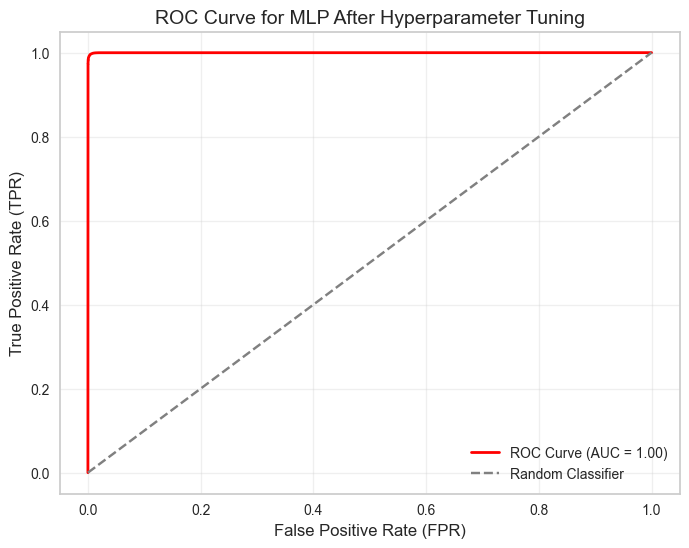

In [8]:
# Hitung probabilitas prediksi untuk kelas positif
y_prob_best_mlp = best_mlp.predict_proba(X_test)[:, 1]

# Hitung nilai False Positive Rate (FPR), True Positive Rate (TPR), dan thresholds
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_prob_best_mlp)

# Hitung nilai AUC untuk MLP
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot ROC Curve untuk MLP
plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='Red', lw=2, label=f'ROC Curve (AUC = {roc_auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curve for MLP After Hyperparameter Tuning', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

Confusion Matrix:
[[53066   295]
 [  166 53280]]


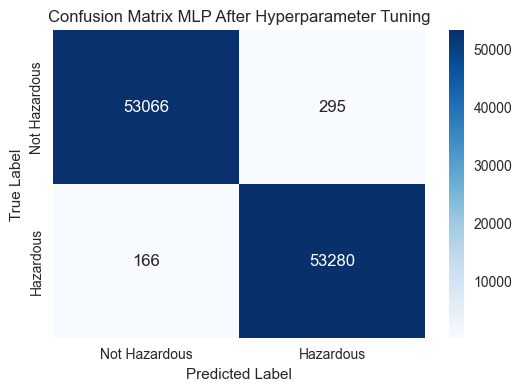

In [9]:
# Confusion Matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_best_mlp)
print("Confusion Matrix:")
print(conf_matrix_mlp)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Hazardous', 'Hazardous'], yticklabels=['Not Hazardous', 'Hazardous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix MLP After Hyperparameter Tuning')
plt.show()

In [10]:
# Menyimpan model MLP terbaik

# Path lokasi penyimpanan
save_path = r"C:\Users\ASUS\Downloads\Hyperparameter Tuning\best_mlp_model.pkl"

# Simpan model
joblib.dump(best_mlp, save_path)

print(f"Model berhasil disimpan ke {save_path}.")


Model berhasil disimpan ke C:\Users\ASUS\Downloads\Hyperparameter Tuning\best_mlp_model.pkl.
